# 1D CNN-based AEs (CAE) for 12Kb windows

In the notebook I am comparing three different CAE architectures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 12000
step_size = window_size / 2
aggregation = 100
chroms = ['chr1', 'chr22']

## Load and normalize the data

#### Download dataset

In [11]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data...')

# GM12878 DNase-seq read-depth normalized signal
bw = 'data/ENCFF158GBQ.bigWig'
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF158GBQ/@@download/ENCFF158GBQ.bigWig',
        'data/ENCFF158GBQ.bigWig',
    )

print('Done!')

Download data...
Done!


#### Retrieved the binned genomic windows

In [12]:
from ae import bigwig

data_train, data_test = bigwig.chunk(
    bw,
    window_size,
    step_size,
    aggregation,
    chroms,
    verbose=True,
)

Chrom: chr1 # win: 41541 Max:   84.65786437988281
Chrom: chr22 # win: 8550 Max:   21.434190273284912


#### Cap data at the 99.9th percentile and normalize to `[0,1]`

In [13]:
from sklearn.preprocessing import MinMaxScaler

cutoff = np.percentile(data_train, (0, 99.9))
data_train_norm = np.copy(data_train)
data_train_norm[np.where(data_train_norm < cutoff[0])] = cutoff[0]
data_train_norm[np.where(data_train_norm > cutoff[1])] = cutoff[1]

cutoff = np.percentile(data_test, (0, 99.9))
data_test_norm = np.copy(data_test)
data_test_norm[np.where(data_test_norm < cutoff[0])] = cutoff[0]
data_test_norm[np.where(data_test_norm > cutoff[1])] = cutoff[1]

print(
    'Train Max: {}'.format(np.max(data_train_norm)),
    'Test Max:  {}'.format(np.max(data_test_norm)),
)

data_train_norm = MinMaxScaler().fit_transform(data_train_norm)
data_test_norm = MinMaxScaler().fit_transform(data_test_norm)

Train Max: 1.621607506275177 Test Max:  2.0269706778862506


#### Filter out the gros of empty windows for the training data

In [22]:
threshold = 3
data_train_norm_filt = data_train_norm[np.where(np.sum(data_train_norm, axis=1) > threshold)]
print('{} out of {} 12Kb windows have at least a total signal of {}.'.format(
    data_train_norm_filt.shape[0],
    data_train_norm.shape[0],
    threshold
))

20488 out of 41541 12Kb windows have at least a total signal of 3.


## Define different CAEs for comparison

In [ ]:
# Load models

In [23]:
# Building CAE

from ae.cnn import cnn2

encoder1, decoder1, autoencoder1 = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 10],
    kernel_sizes=[11, 7, 3],
    summary=False,
    dr=True
)

encoder2, decoder2, autoencoder2 = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 6],
    kernel_sizes=[11, 9, 5],
    summary=False,
    dr=True
)

encoder3, decoder3, autoencoder3 = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 6],
    kernel_sizes=[9, 5, 3],
    summary=False,
    dr=True
)

## Train the CAEs

In [25]:
from ae.utils import train

epochs = 1
batch_size = 256

train(
    autoencoder1,
    data_train_norm_filt.reshape(data_train_norm_filt.shape[0], data_train_norm_filt.shape[1], 1),
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder2,
    data_train_norm_filt.reshape(data_train_norm_filt.shape[0], data_train_norm_filt.shape[1], 1),
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder3,
    data_train_norm_filt.reshape(data_train_norm_filt.shape[0], data_train_norm_filt.shape[1], 1),
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 20488 samples, validate on 8550 samples
Epoch 1/1
20488/20488 [==============================] - 26s 1ms/step - loss: 0.2511 - val_loss: 0.1266
Train on 20488 samples, validate on 8550 samples
Epoch 1/1
20488/20488 [==============================] - 36s 2ms/step - loss: 0.2508 - val_loss: 0.1368
Train on 20488 samples, validate on 8550 samples
Epoch 1/1
20488/20488 [==============================] - 26s 1ms/step - loss: 0.2530 - val_loss: 0.1326


#### Save the models

In [7]:
# encoder1.save('models/encode-gm12878-dnase-seq-2011-encoder-chr1-chr22-new-cnn.h5')
# decoder1.save('models/encode-gm12878-dnase-seq-2011-decoder-chr1-chr22-new-cnn.h5')
# autoencoder1.save('models/encode-gm12878-dnase-seq-2011-autoencoder-chr1-chr22-new-cnn.h5')

## Predict encodings

In [28]:
from keras.metrics import binary_crossentropy
from ae.utils import predict

predicted1, loss1, _ = predict(
    encoder1,
    decoder1,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted1 = predicted1.reshape(predicted1.shape[0], predicted1.shape[1])

predicted2, loss2, _ = predict(
    encoder2,
    decoder2,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted2 = predicted2.reshape(predicted2.shape[0], predicted2.shape[1])

predicted2, loss2, _ = predict(
    encoder2,
    decoder2,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted2 = predicted2.reshape(predicted2.shape[0], predicted2.shape[1])

## Visualize preditions

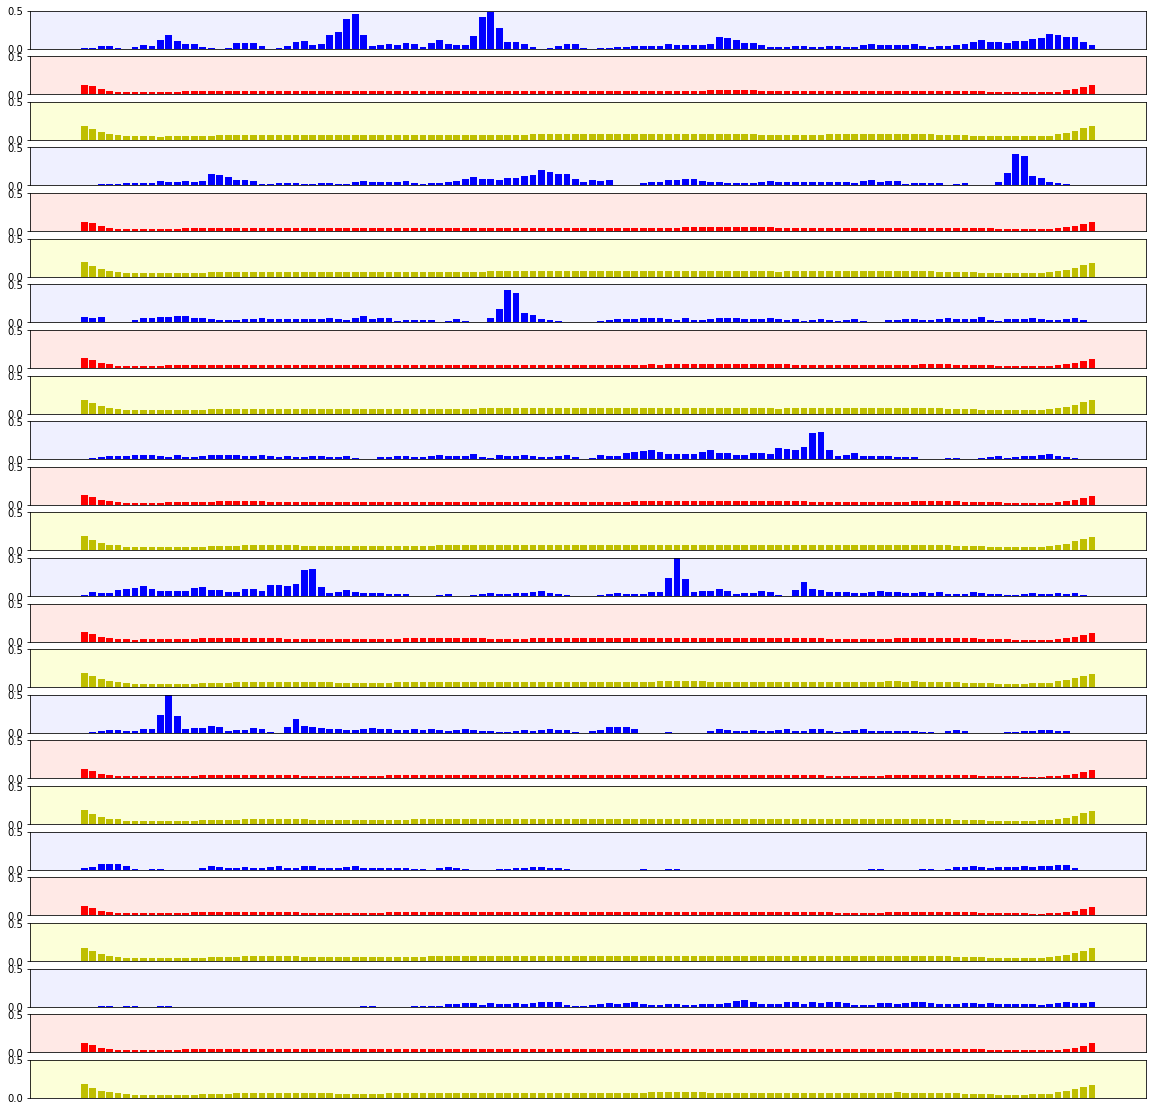

In [31]:
import matplotlib.pyplot as plt

n = 8
offset = 5920

ymax = 0.5

plt.figure(figsize=(20, 20))
for i in range(n):
    k = i + offset
    
    # display original
    ax = plt.subplot(n * 3, 1, i * 3 + 1)
    ax.set_facecolor('#EFF0FF')
    plt.bar(np.arange(data_test_norm[k].size), data_test_norm[k], color='b')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n * 3, 1, i * 3 + 2)
    ax.set_facecolor('#FFE9E6')
    plt.bar(np.arange(predicted1[k].size), predicted1[k], color='r')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n * 3, 1, i * 3 + 3)
    ax.set_facecolor('#FCFFD9')
    plt.bar(np.arange(predicted2[k].size), predicted2[k], color='y')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
plt.show()

#### Visualize the best and worse windows in terms of loss

The top blueish plots show the best predictions and the redish ones at the bottom show the worse predictions. The ground truth is plotted semi-transparently in gray.

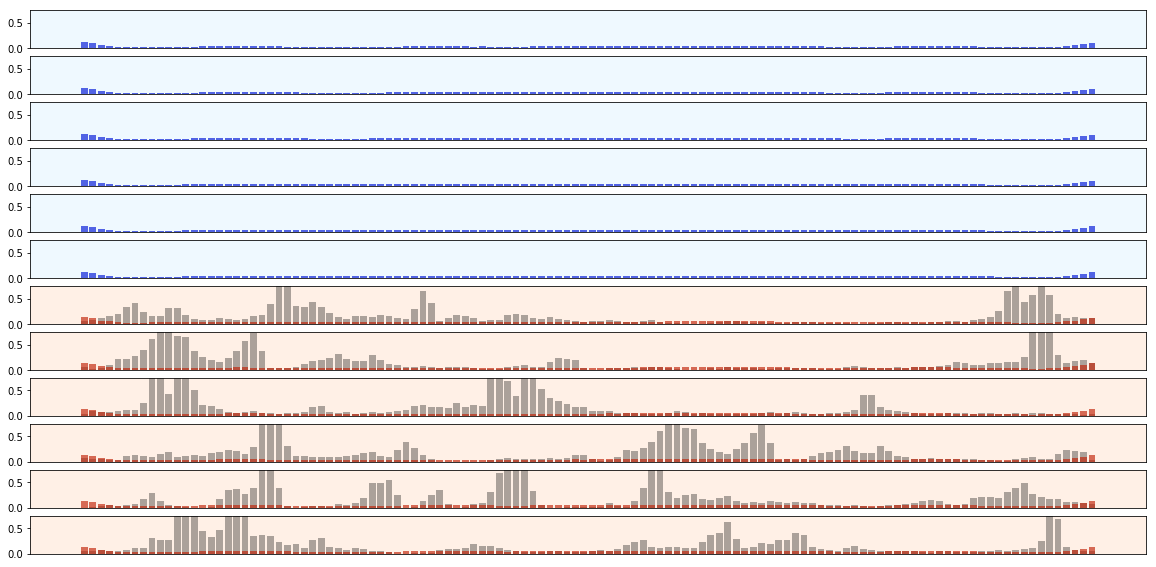

In [41]:
import matplotlib.pyplot as plt

examples = 6
n = examples * 2

best_worst = np.argsort(loss1)
best_worst = np.concatenate((best_worst[:examples], best_worst[-examples:]))

plt.figure(figsize=(20, 10))
for i, k in enumerate(best_worst):
    ymax = np.max(data_test_norm[k])
    
    if i < examples:
        ca = '#000000'
        bgca = '#eff9ff'
        cb = '#0015d6'
    else:
        ca = '#000000'
        bgca = '#fff0e6'
        cb = '#c12409'
    
    # display original
    ax = plt.subplot(n, 1, i + 1)
    ax.set_facecolor(bgca)
    plt.bar(np.arange(data_test_norm[i].size), data_test_norm[k], color=ca, alpha=0.33)
    plt.bar(np.arange(predicted1[k].size), predicted1[k], color=cb, alpha=0.66)
    plt.ylim(0, 0.75)
    ax.get_xaxis().set_visible(False)
plt.show()